<a href="https://colab.research.google.com/github/Aasthaadhikari01/SeismoGraphGPT--Ai-Based-Earthquake-Prediction/blob/main/SesismoGraphGPT_AI_based_Earthquake_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install any missing libraries first
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
file_path = '/content/earthquake_data.csv'
df = pd.read_csv(file_path)

In [4]:
# Preview data
print(df.shape)
df.head()

(782, 19)


,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


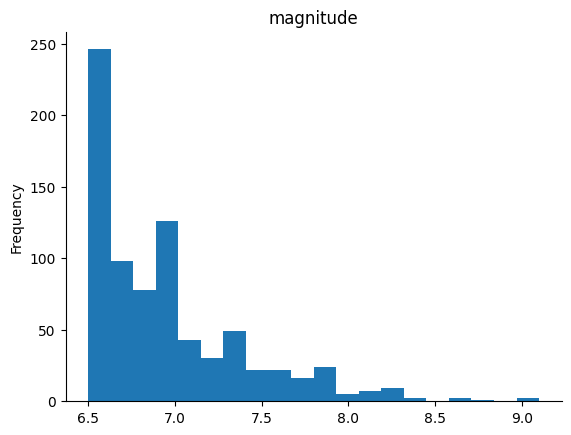

In [35]:
# @title magnitude

from matplotlib import pyplot as plt
df['magnitude'].plot(kind='hist', bins=20, title='magnitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
# Check for missing values
print(df.isnull().sum())


title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        367
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       5
continent    576
country      298
dtype: int64


In [6]:
# Drop rows with missing important values (optional: you can fillna if preferred)
df = df.dropna(subset=['latitude', 'longitude', 'depth', 'magnitude'])


In [7]:
# Normalize magnitude (optional but good for ML)
df['norm_mag'] = (df['magnitude'] - df['magnitude'].min()) / (df['magnitude'].max() - df['magnitude'].min())

In [8]:
# Normalize depth
df['norm_depth'] = (df['depth'] - df['depth'].min()) / (df['depth'].max() - df['depth'].min())

In [9]:
# Create a time feature if timestamp exists
# Convert 'date_time' column into datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract date and time features
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['minute'] = df['date_time'].dt.minute


<ipython-input-9-8cd03223708e>:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


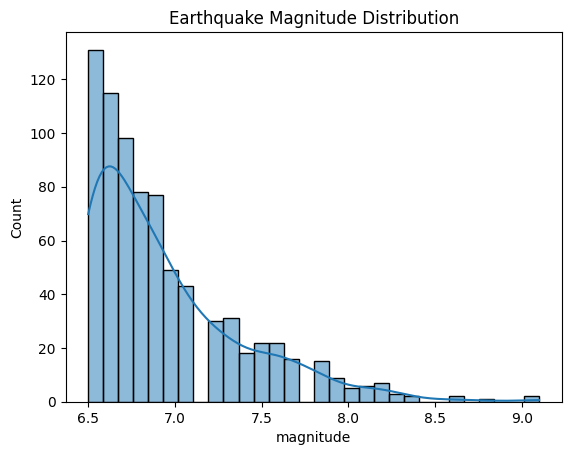

In [10]:
# Plot distribution of earthquake magnitudes
sns.histplot(df['magnitude'], bins=30, kde=True)
plt.title('Earthquake Magnitude Distribution')
plt.show()

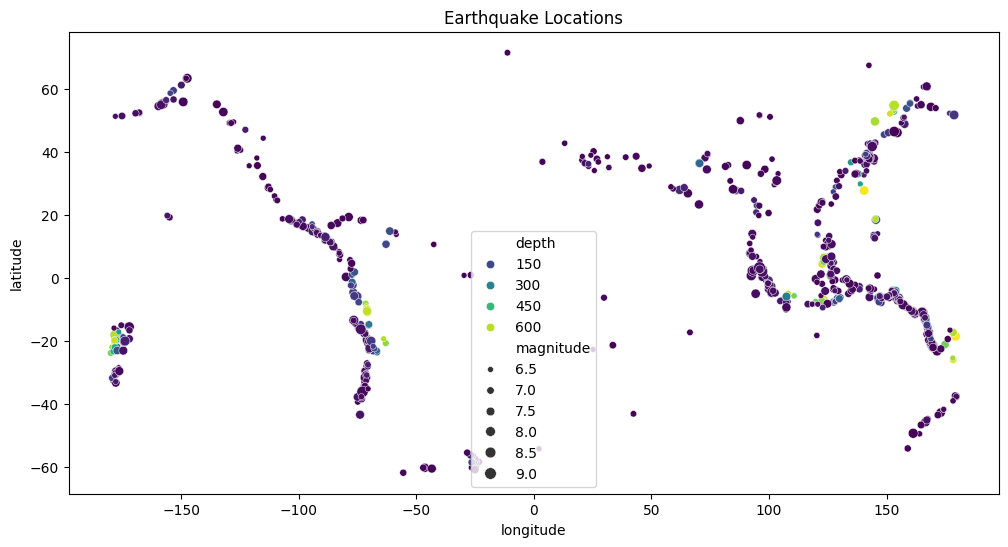

In [11]:
# Plot locations
plt.figure(figsize=(12,6))
sns.scatterplot(x='longitude', y='latitude', size='magnitude', hue='depth', data=df, palette='viridis')
plt.title('Earthquake Locations')
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from sklearn.model_selection import train_test_split

In [13]:
# Feature columns
features = ['latitude', 'longitude', 'depth', 'norm_depth', 'norm_mag', 'year', 'month', 'day', 'hour', 'minute']

# Label column
label = 'norm_mag'

In [14]:
X = df[features]
y = df[label]

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Reshape input for LSTM and Transformer (batch_size, timesteps, features)
# We'll treat each sample as one timestep (1) with 10 features
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [17]:
# Model Architecture
def build_transformer_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # Transformer Block
    x = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
    x = LayerNormalization()(x)
    x = Add()([x, inputs])  # Residual connection

    # LSTM Block
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense Layers
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
# Build Model
input_shape = (X_train.shape[1], X_train.shape[2])  # (1, 10)
model = build_transformer_lstm_model(input_shape)

In [19]:
# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [20]:
# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 10)     │      2,762 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 10)     │         20 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 10)     │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     19,200 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,095 (94.12 KB)

 Trainable params: 24,095 (94.12 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1300 - mae: 0.2844 - val_loss: 0.0305 - val_mae: 0.1509
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0760 - mae: 0.2161 - val_loss: 0.0323 - val_mae: 0.1591
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0556 - mae: 0.1834 - val_loss: 0.0339 - val_mae: 0.1630
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0494 - mae: 0.1773 - val_loss: 0.0289 - val_mae: 0.1491
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0400 - mae: 0.1582 - val_loss: 0.0260 - val_mae: 0.1400
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0388 - mae: 0.1517 - val_loss: 0.0231 - val_mae: 0.1290
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0368 - mae: 0.1488 - val_loss: 0.0227 - val_mae: 0.1275
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0403 - mae: 0.1584 - val_loss: 0.0225 - val_mae: 0.1270
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0373 - ma

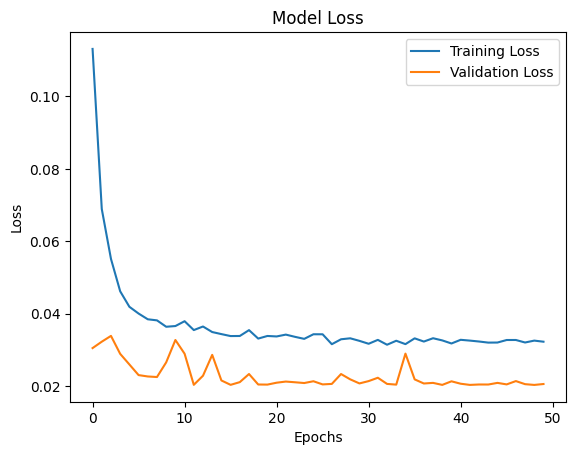

In [22]:
# Plot Loss Curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

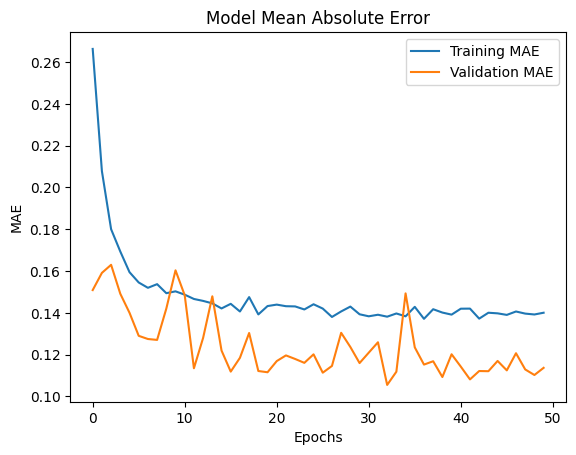

In [23]:
# Plot MAE Curves
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [24]:
!pip install -U jupyter-dash dash==2.11.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [25]:
!pip install dash
!pip install jupyter-dash
!pip install plotly


In [26]:
# Imports
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.express as px

In [27]:
# Load the latest data (same df we processed)
latest_df = df.tail(100)  # Last 100 earthquakes for display

In [28]:
# Predict magnitudes for latest_df
X_latest = latest_df[features]
X_latest = np.expand_dims(X_latest, axis=1)
predicted_magnitudes = model.predict(X_latest).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [29]:
latest_df = df.tail(100).copy()
# Add predictions to DataFrame
latest_df['predicted_norm_mag'] = predicted_magnitudes
latest_df['predicted_mag'] = predicted_magnitudes * (df['magnitude'].max() - df['magnitude'].min()) + df['magnitude'].min()

In [30]:
# Simple anomaly detection: if predicted magnitude > 5.5
latest_df['alert'] = latest_df['predicted_mag'].apply(lambda x: '🚨 ALERT' if x > 5.5 else '✅ Safe')

In [31]:
# Create a Dash App
app = JupyterDash(__name__)

/usr/local/lib/python3.11/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.
  warnings.warn(


In [32]:
app.layout = html.Div([
    html.H1("🌍 Earthquake Prediction Dashboard - SeismoGraphGPT Lite"),

    dcc.Graph(id='map-graph',
              figure=px.scatter_mapbox(latest_df,
                                       lat="latitude",
                                       lon="longitude",
                                       color="alert",
                                       size="predicted_mag",
                                       hover_name="place" if "place" in latest_df.columns else "latitude",
                                       hover_data=["predicted_mag"],
                                       zoom=1,
                                       mapbox_style="open-street-map")),

    dcc.Interval(id='refresh', interval=60000, n_intervals=0),

    html.Div(id='text-output')
])

In [33]:
# Callback for updating text (optional)
@app.callback(
    Output('text-output', 'children'),
    Input('refresh', 'n_intervals')
)
def update_text(n):
    alerts = latest_df[latest_df['alert'] == '🚨 ALERT']
    if len(alerts) > 0:
        return html.Div([
            html.H3('🚨 Active Alerts:'),
            html.Ul([html.Li(f"Predicted {row['predicted_mag']:.2f} magnitude at ({row['latitude']}, {row['longitude']})")
                     for idx, row in alerts.iterrows()])
        ])
    else:
        return html.Div([
            html.H3('✅ No active alerts.')
        ])


In [34]:
# Imports for JupyterDash
from jupyter_dash import JupyterDash

# Run Dash app in "external" mode
app.run_server(mode='external', debug=True)


Dash app running on:
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>